In [2]:
import pandas as pd
from datetime import datetime

from pmdarima.arima.utils import ndiffs, nsdiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt

In [4]:
path = f"/masters_diploma/processed_data/history_weather.csv"

full_set = pd.read_csv(
    path,
    parse_dates=["date"],
    index_col=["date"],
)

In [5]:
full_set

,temperature,relative_humidity,dew_point,precipitation,rain,snowfall,weather_code,pressure_msl,surface_pressure,cloud_cover,...,sunshine_duration_max_3_years,sunshine_duration_min_3_years,sunshine_duration_mean_3_years,sunshine_duration_max_4_years,sunshine_duration_min_4_years,sunshine_duration_mean_4_years,sunshine_duration_lag_24,sunshine_duration_lag_48,sunshine_duration_lag_72,sunshine_duration_lag_168
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-5.9,56.0,-13.3,0.0,0.0,0.07,71.0,1026.1,1001.8,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,-5.5,59.0,-12.4,0.0,0.0,0.00,3.0,1025.1,1000.8,97.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,-5.2,63.0,-11.2,0.0,0.0,0.00,3.0,1024.7,1000.5,100.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,-4.9,68.0,-9.9,0.0,0.0,0.00,3.0,1024.3,1000.1,99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 04:00:00,-4.6,73.0,-8.7,0.0,0.0,0.07,71.0,1024.1,1000.0,98.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-25 19:00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-09-25 20:00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-09-25 21:00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
temp = full_set['temperature']
exog = full_set[['month', 'year_day', 'is_day', 'sunshine_duration_mean_7_days', 'sunshine_duration_mean_7_weeks', 'temperature_min_3_weeks', 'temperature_max_3_weeks', 'temperature_mean_3_weeks',
         'temperature_min_3_years', 'temperature_max_3_years', 'temperature_mean_3_years', 'cloud_cover_mean_7_days', 'pressure_msl_mean_7_days']]

temp = temp.asfreq(pd.infer_freq(temp.index) or "H")
exog = exog.reindex(temp.index).interpolate(limit_direction="both")

In [9]:
train_start = datetime(2023, 9, 1, 0)
train_end = datetime(2025, 8, 31, 23)
test_start = datetime(2025, 9, 1, 0)
test_end = datetime(2025, 9, 14, 23)

In [10]:
X_train = exog.loc[train_start: train_end]
X_test = exog.loc[test_start: test_end]

y_train = temp.loc[train_start: train_end]
y_test = temp.loc[test_start: test_end]

In [24]:
d = ndiffs(temp, alpha=0.05, test='kpss')
D = nsdiffs(temp, m=24, max_D=1, test='ocsb') 

d, D

(1, 0)

In [8]:
model_arima = ARIMA(y_train, order=(2, 1, 3))
result_arima = model_arima.fit()

ar_forecast = result_arima.forecast(steps=len(y_test))

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
model_sarimax = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 24))
result_sarimax = model_sarimax.fit(disp=False)

sar_forecast = result_sarimax.get_forecast(steps=len(y_test), exog=X_test).predicted_mean

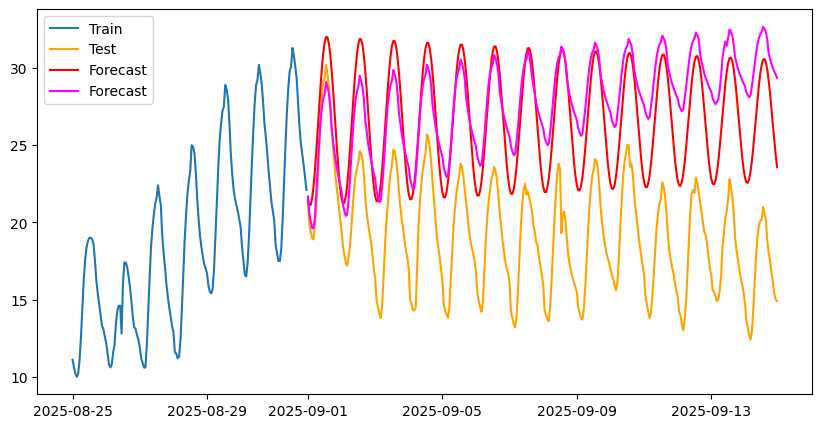

In [20]:
plt.figure(figsize=(10,5))
plt.plot(y_train.loc['2025-08-25':], label="Train")
plt.plot(y_test, label="Test", color="orange")
plt.plot(ar_forecast, label="Forecast", color="red")
plt.plot(sar_forecast, label="Forecast", color="magenta")
plt.legend()
plt.show()

In [13]:
subset = pd.concat([
    full_set.loc["2024-01-01":"2024-01-01 23:00", ["is_day", "sunshine_duration"]],
    full_set.loc["2025-01-01":"2025-01-01 23:00", ["is_day", "sunshine_duration"]]
])
subset

,is_day,sunshine_duration
date,,
2024-01-01 00:00:00,0.0,0.00
2024-01-01 01:00:00,0.0,0.00
2024-01-01 02:00:00,0.0,0.00
2024-01-01 03:00:00,0.0,0.00
2024-01-01 04:00:00,0.0,0.00
2024-01-01 05:00:00,0.0,0.00
2024-01-01 06:00:00,1.0,0.00
2024-01-01 07:00:00,1.0,0.00
2024-01-01 08:00:00,1.0,3600.00
